<center><h2>SparkML: Machine Learning Models</h2></center>

# 1. Data Ingestion, Preprocessing, and Tuning for Logistic Regression


In [3]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0)
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [5]:
# if you installed Spark on windows, 
# you may need findspark and need to initialize it prior to being able to use pyspark
# Also, you may need to initialize SparkContext yourself.
# Uncomment the following lines if you are using Windows!
#import findspark
#findspark.init()
#findspark.find()

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('/home/reid/Projects/systems_and_toolchains/NSL-KDD/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('/home/reid/Projects/systems_and_toolchains/NSL-KDD/KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)


nslkdd_df.cache()
nslkdd_df_test.cache()

24/10/02 15:47:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[features: vector, outcome: double]

Let's also rerun the tuning for cross validation as we will do comparisons with logistic regression later. 


In [6]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sklearn.metrics import roc_curve
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy
from matplotlib import pyplot as plt

# Estimator
lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')

# ParameterGrid
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

# Evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
    labelCol='outcome', metricName='areaUnderROC')

# CrossValidator
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                    evaluator=evaluator, numFolds=5)

# Hyper Parameter Tuning via cross validation
lr_cv_model = lr_cv.fit(nslkdd_df)

# Make predictions on the test data set and compute the fpr, tpr, and AUC
lr_cv_prediction_test = lr_cv_model.transform(nslkdd_df_test)
outcome_true = lr_cv_prediction_test.select('outcome').toPandas() # the true outcome label as Pandas df

to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

lr_cv_pred_prob = (lr_cv_prediction_test.select("probability").
        withColumn('probability', to_array('probability')).toPandas())
lr_cv_pred_prob = np.array(lr_cv_pred_prob['probability'].values.tolist())

lr_cv_fpr, lr_cv_tpr, lr_cv_thresholds = roc_curve(outcome_true, lr_cv_pred_prob[:,1])

lr_cv_auc = evaluator.evaluate(lr_cv_prediction_test)

24/10/02 15:47:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


# 2. Support Vector Machine



So far we have trained, tuned and evaluated the **logistic regression** model for classification. Logistic regression is perhaps one of the simpliest models for classification and is a good starting point, but their performance is usually not the best because of the linear relationshiop between the feature and the score. 

We now will go through a range of other modern ML models that are commonly used in the industry.


- Support vector machine (SVM)

- Tree-like models, including decision tree, random forest. 

- Naive Bayes

Let's start with SVM. The pros and cons of SVM are summarized as follows. 

**Pros of SVM**

- SVM is not sensitive to (some) outliers. Only the points at the boundary will determine the decision boundary. Outlier points, as long as they do not affect the boundary, will be "ignored". 

- SVM also enjoys certain computational/memory benefits as only "boundary" points are used to compute the decision boundary. 

- Another advantage of SVM is the ''kernel trick'' that allows nonlinear decision boundaries. Unfortunately this feature is not supported by SparkML right now. 

**Cons of SVM**

- Does not provide a probability estimate, only rawPredictions. 

- Works less well when the two classes are "overlapping", i.e. the boundary is not clearly defined. 


Let's implement SVM using SparkML. The process is very similar to logistic regression. 

In [7]:
# The implementation of SVM on spark ML is pretty straightforward - just find the right class from the sparkml library

from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol="features",labelCol = "outcome")

svm_model = svm.fit(nslkdd_df)



In [8]:

# make predictions on training dataset and test data set
svm_prediction_train = svm_model.transform(nslkdd_df)
svm_prediction_test = svm_model.transform(nslkdd_df_test)

# calculate train and test accuracy
svm_accuracy_train = (svm_prediction_train.filter(
    svm_prediction_train.outcome == svm_prediction_train.prediction).count() / 
    float(svm_prediction_train.count()))
svm_accuracy_test = (svm_prediction_test.filter(
    svm_prediction_test.outcome == svm_prediction_test.prediction).count()
    / float(svm_prediction_test.count()))
    
# calculate AUC
svm_auc = evaluator.evaluate(svm_prediction_test)

print(f"Train accuracy = {np.round(svm_accuracy_train*100,2)}%")
print(f"Test accuracy = {np.round(svm_accuracy_test*100,2)}%")
print(f"AUC = {np.round(svm_auc,2)}")

Train accuracy = 97.5%
Test accuracy = 75.39%
AUC = 0.82


We will also tune the hyper-parameters (maxIter, regParam) for SVM. Their meanings are quite similar as in the case of logistic regression. 


In [9]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

svm = LinearSVC(featuresCol="features",labelCol = "outcome")

svm_paramGrid = (ParamGridBuilder()
             .addGrid(svm.regParam, [0.01, 0.5, 2.0])# regularization parameter
             .addGrid(svm.maxIter, [10, 50, 100])#Number of iterations
             .build())

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
    labelCol='outcome', metricName='areaUnderROC')

svm_cv = CrossValidator(estimator=svm, estimatorParamMaps=svm_paramGrid, 
                    evaluator=evaluator, numFolds=5)

svm_cv_model = svm_cv.fit(nslkdd_df)


24/10/02 15:52:25 WARN BlockManager: Asked to remove block broadcast_6924, which does not exist


Let's evaluate the performance of the tuned SVM and compare it with logistic regression. 

In [10]:
svm_cv_prediction_test = svm_cv_model.transform(nslkdd_df_test)

svm_cv_auc = evaluator.evaluate(svm_cv_prediction_test)

print(f"Before cross-validation and parameter tuning, AUC={np.round(svm_auc,2)}")
print(f"After cross-validation and parameter tuning, AUC={np.round(svm_cv_auc,2)}")


Before cross-validation and parameter tuning, AUC=0.82
After cross-validation and parameter tuning, AUC=0.83


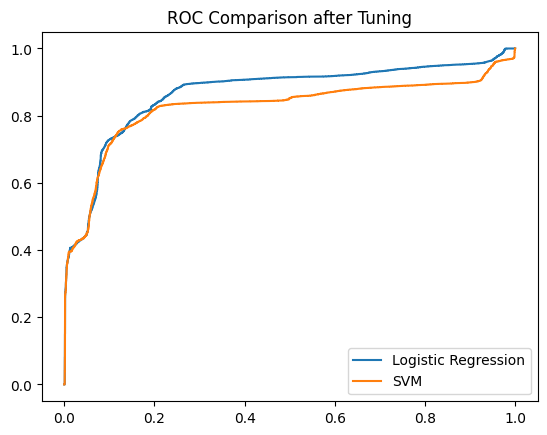

In [11]:

svm_cv_prediction_raw = np.array(
    svm_cv_prediction_test.select("rawPrediction").toPandas().values.tolist()).squeeze()

svm_cv_fpr, svm_cv_tpr,_ = roc_curve(outcome_true,svm_cv_prediction_raw[:,1])

plt.figure()
plt.plot(lr_cv_fpr,lr_cv_tpr,label='Logistic Regression')
plt.plot(svm_cv_fpr,svm_cv_tpr,label='SVM')
plt.title('ROC Comparison after Tuning')
plt.legend()


# 3. Tree Like Models

## 3.1 Decision Tree

A decision tree builds upon iteratively asking questions to partition data. It is easier to conceptualize the partitioning data with a visual representation of a decision tree.

<center><figure><img src="http://stat.cmu.edu/~mfarag/14810/l17/decision_tree.png"/><figcaption>Image taken from <a href="https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Decision-Tree-Example">here</a></figcaption></figure></center>

## 3.2 Random Forest

One decision tree is prone to overfitting. To reduce the risk of overfitting, models that combine many decision trees are preferred. These combined models also have better performance. Random forests use a method called bagging to combine many decision trees to create an ensemble. Bagging simply means combining in parallel. Random forest also uses other tricks to reduce overfitting, including bootstrap sampling, and feature subsampling. 

The implementation of random forest in sparkML is very straightforward. 

In [12]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'outcome')
rf_model = rf.fit(nslkdd_df)



As usual, `rf_model` is now a Transformer and we now use it to make predictions on both the training dataset and the test dataset. We also calculate the train and test accuracy as well as the AUC. 

In [13]:
rf_prediction_train = rf_model.transform(nslkdd_df)
rf_prediction_test = rf_model.transform(nslkdd_df_test)

rf_accuracy_train = (rf_prediction_train.filter(rf_prediction_train.outcome == rf_prediction_train.prediction)
    .count()/ float(rf_prediction_train.count()))
rf_accuracy_test = (rf_prediction_test.filter(rf_prediction_test.outcome == rf_prediction_test.prediction)
    .count() / float(rf_prediction_test.count()))

rf_auc = evaluator.evaluate(rf_prediction_test)

print(f"Train accuracy = {np.round(rf_accuracy_train*100,2)}%, test accuracy = {np.round(rf_accuracy_test*100,2)}%, AUC = {np.round(rf_auc,2)}")

Train accuracy = 97.71%, test accuracy = 74.64%, AUC = 0.95


### Hyper-Parameter Tuning for Random Forest

Two key parameters for random forest is maxDepth (maximum allowed depth in each tree), and numTrees (the number of trees). Let's tune the two parameters with cross-validation. 

In [14]:
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15])# maximum depth for each tree
             .addGrid(rf.numTrees,[10, 20, 40])# number of trues
             .build())

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, 
                    evaluator=evaluator, numFolds=5)

rf_cv_model = rf_cv.fit(nslkdd_df)

rf_cv_prediction_test = rf_cv_model.transform(nslkdd_df_test)
rf_cv_auc = evaluator.evaluate(rf_cv_prediction_test)





24/10/02 16:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1139.8 KiB
24/10/02 16:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1420.3 KiB
24/10/02 16:07:55 WARN DAGScheduler: Broadcasting large task binary with size 1083.5 KiB
24/10/02 16:07:55 WARN DAGScheduler: Broadcasting large task binary with size 1216.6 KiB
24/10/02 16:07:55 WARN DAGScheduler: Broadcasting large task binary with size 1336.3 KiB
24/10/02 16:07:55 WARN DAGScheduler: Broadcasting large task binary with size 1437.7 KiB
24/10/02 16:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1139.8 KiB
24/10/02 16:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1420.3 KiB
24/10/02 16:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1704.4 KiB
24/10/02 16:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1968.1 KiB
24/10/02 16:07:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/10/02 16:07:59 WARN D

In [15]:
print(f"Before cross-validation and parameter tuning, AUC={np.round(rf_auc,2)}")
print(f"After cross-validation and parameter tuning, AUC={np.round(rf_cv_auc,2)}")


Before cross-validation and parameter tuning, AUC=0.95
After cross-validation and parameter tuning, AUC=0.97


24/10/02 16:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1598.2 KiB


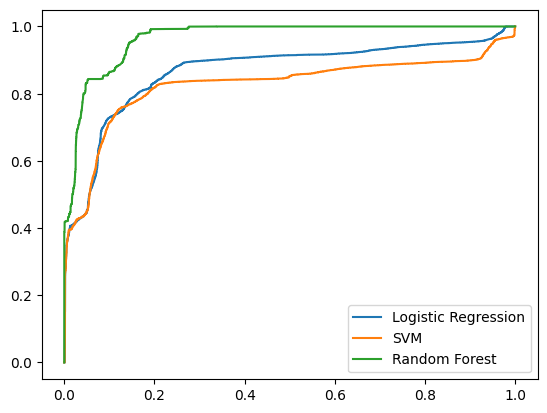

In [16]:
rf_prediction_score = np.array(rf_cv_prediction_test.select("rawPrediction").toPandas().values.tolist()).squeeze()
rf_cv_fpr, rf_cv_tpr,_ = roc_curve(outcome_true,rf_prediction_score[:,1])

plt.figure()
plt.plot(lr_cv_fpr,lr_cv_tpr,label = 'Logistic Regression')
plt.plot(svm_cv_fpr,svm_cv_tpr,label='SVM')
plt.plot(rf_cv_fpr,rf_cv_tpr,label='Random Forest')

plt.legend()

# 4. Naive Bayes 



Naive bayes is a generative probability model used for classification problems. It is the prime model used for text classifications, where the number of features is very large. It is extensively used for sentiment analysis, spam filtering etc.

This model is based on the Bayes Rule which can be stated as the following:

<center><figure><img src="http://stat.cmu.edu/~mfarag/14810/l17/bayes_rule.png"/><figcaption></figcaption></figure></center>
<ul>
<li>P(A|B) : (posterior probability) probability of event A to happen when event B is true.</li>
<li>P(A) ,P(B) : probability of event A and event B to happen.</li>
    <li>P(B|A) : (likelihood) probability of event B to happen when event A is true.</li>
    </ul>

The basic logic is to derive the probability of output label $Y = C_i$ given the input $x$ , from individual probabilities of features($x_i$) given output label as $Y = C_i$ (which can be infered from the training data).

<center><figure><img src="http://stat.cmu.edu/~mfarag/14810/l17/naive_bayes.png"/><figcaption></figcaption></figure></center>

The major assumption of naive bayes is that all features tend to be mutually independent. It sometimes does not work well as not all data satisfy this assumption. However, it does have several advantages:
<ul>
    <li>It works well with less training data.</li>
    <li>Handles irrelevant features.</li>
    <li>Supports binary and multi-class classification problems.</li>
    </ul>
    
 Now, let's look at the code. The first step is to create the Estimator `NaiveBayes` and the run the `fit` method. 

In [17]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol = 'features', labelCol = 'outcome', modelType = "gaussian" )
nb_model = nb.fit(nslkdd_df)



Then, we use the fitted model to transform both the training and the test dataset, and calculate the train/test accuracy and the AUC. 

In [18]:
nb_prediction_train = nb_model.transform(nslkdd_df)
nb_prediction_test = nb_model.transform(nslkdd_df_test)

nb_accuracy_train = (nb_prediction_train.filter(nb_prediction_train.outcome == nb_prediction_train.prediction)
    .count() / float(nb_prediction_train.count()))
nb_accuracy_test = (nb_prediction_test.filter(nb_prediction_test.outcome == nb_prediction_test.prediction)
    .count() / float(nb_prediction_test.count()))
nb_auc = evaluator.evaluate(nb_prediction_test)

print(f"Train accuracy = {np.round(nb_accuracy_train*100,2)}%, test accuracy = {np.round(nb_accuracy_test*100,2)}%, AUC = {np.round(nb_auc,2)}")


Train accuracy = 70.98%, test accuracy = 51.23%, AUC = 0.6


Finally, let's compare the ROC curve of all the tuned models we have tried so far. 

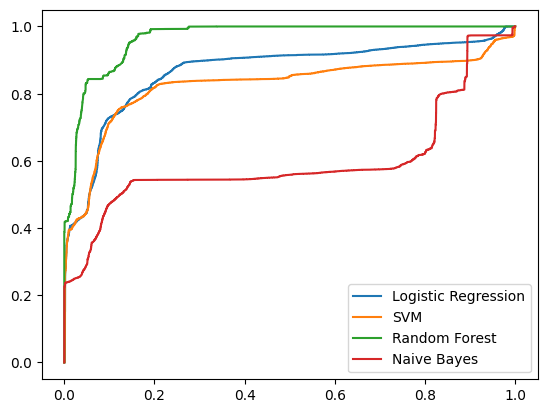

In [19]:
nb_prediction_score = np.array(nb_prediction_test.select("rawPrediction").toPandas().values.tolist()).squeeze()

nb_cv_fpr, nb_cv_tpr,_ = roc_curve(outcome_true,nb_prediction_score[:,1])


plt.figure()
plt.plot(lr_cv_fpr,lr_cv_tpr,label = 'Logistic Regression')
plt.plot(svm_cv_fpr,svm_cv_tpr,label='SVM')
plt.plot(rf_cv_fpr,rf_cv_tpr,label='Random Forest')
plt.plot(nb_cv_fpr,nb_cv_tpr,label='Naive Bayes')

plt.legend()